作者： 姚舜禹  
https://doi.org/10.20944/preprints202510.1834.v1

SimProfile: A Monte Carlo Surface Profile Simulator with Data-Driven Parameter Calibration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm
import matplotlib.patches as mpatches

第1段階では、マスク材料に対するイオン入射時sputter yieldパラメータを較正する。

```bash
python3 Skopt_paper_1009.py
```

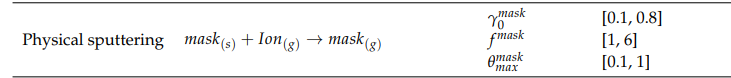

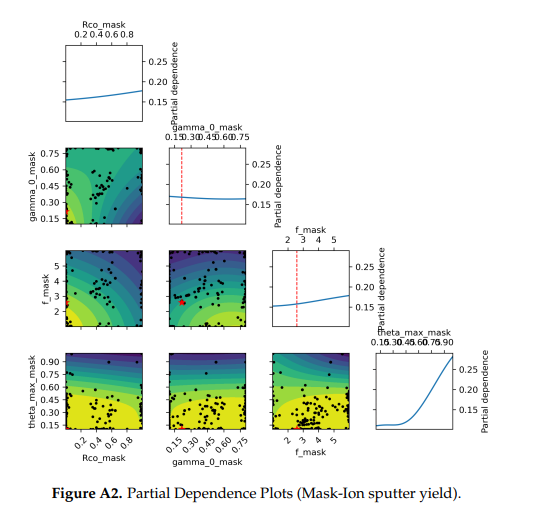

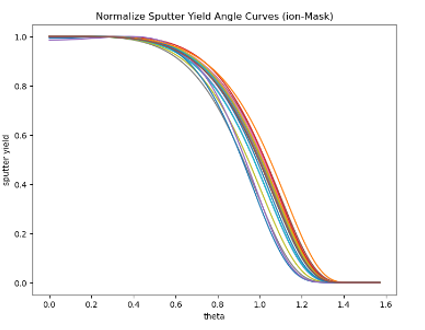

In [ ]:
import calibration_simplefilm_tpe_0418_fitting_o2
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_evaluations
from skopt.plots import plot_objective
from skopt.callbacks import CheckpointSaver
from skopt import load

import os
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize

In [ ]:
def plot_convergence(name, result, true_minimum=None, yscale=None, title="Convergence plot"):

    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("iterations $n$")
    ax.set_ylabel(r"$\min\ loss$ after $n$ calls")
    ax.grid()
    if yscale is not None:
        ax.set_yscale(yscale)
    colors = cm.hsv(np.linspace(0.25, 1.0, len(result)))  # Update this line


    # name, result = result
    n_calls = len(result.x_iters)

    print("Number of calls:", n_calls)
    iterations = range(1, n_calls + 1)
    mins = [np.min(result.func_vals[:i]) for i in iterations]
    # print('mins: ',mins)
    ax.plot(iterations, mins, c='red', label=name)
        #ax.errorbar(iterations, np.mean(mins, axis=0),
        #             yerr=np.std(mins, axis=0), c=color, label=name)
    if true_minimum:
        ax.axhline(true_minimum, linestyle="--",
                   color="r", lw=1,
                   label="True minimum")
    ax.legend(loc="best")
    return ax

In [ ]:
def overlap_show(n, img1_path, img2_path, path_dir, overlap_range=np.array([[0, -1], [0, -1]])):
    # 读取两张图像
    # img1_path = "./sf_o2_paper1.jpg"
    # img2_path = "./sf_o2_paper2.jpg"

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # n = 1
    # binary1= np.load(f'./save_film/film_0_1_0520_1.npy')
    binary1 = np.load(f'./{path_dir}/film_0_{n}.npy')

    binary1 = np.sum(binary1, axis=-1)
    binary1 = binary1[int(binary1.shape[0]/2), :, :]
    new_binary1 = np.zeros((binary1.shape[1], binary1.shape[0]))
    print(new_binary1.shape)
    for i in range(binary1.shape[1]):
        new_binary1[new_binary1.shape[0] - i-1, :] = binary1[:, i]

    img1 = new_binary1


    # 调整图像大小，使它们具有相同的尺寸
    height, width = img1.shape[:2]
    img2_resized = cv2.resize(img2, (width, height))

    # 转换为灰度图
    # gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)

    # 二值化处理
    # _, binary1 = cv2.threshold(gray1, 80, 255, cv2.THRESH_BINARY)
    binary1 = new_binary1


    _, binary2 = cv2.threshold(gray2, 80, 255, cv2.THRESH_BINARY)

    # binary2 = cv2.bitwise_not(binary2).astype(np.uint8)
    # binary1 = binary1.astype(np.uint8)

    binary1 = (binary1 > 10).astype(np.uint8) * 255
    # binary2 = (binary2 > 128).astype(np.uint8) * 255

    x1 = overlap_range[0, 0]
    x2 = overlap_range[0, 1]
    y1 = overlap_range[1, 0]
    y2 = overlap_range[1, 1]
    binary1 = binary1[x1:x2, y1:y2]
    binary2 = binary2[x1:x2, y1:y2]
    # 计算重叠区域
    intersection = binary1 == binary2  # 计算交集

    SimCD = intersection == binary1
    ExpCD = intersection == binary2
    # print(intersection)
    # print(binary1)
    # print(binary2)

    overlap_ratio = np.sum(intersection) / (intersection.shape[0]*intersection.shape[1])


    overlap = intersection*0.5
    overlap[0,0] = 0.4
    overlap[0,-1] = 0.6
    overlap[SimCD] = 0.4
    overlap[ExpCD] = 0.6

    # overlap_ratio = np.sum(intersection) / (intersection.shape[0]*intersection.shape[1])


    # overlap = intersection*255
    # overlap_ratio = np.sum(overlap) / np.sum(binary2)  # 计算相对于 mask 的重叠度

    # 显示结果
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(binary1, cmap='gray')
    axes[0].set_title("simulation")

    axes[1].imshow(binary2, cmap='gray')
    axes[1].set_title("experiment")

    cmap = plt.colormaps['RdBu']
    axes[2].imshow(overlap, cmap=cmap)

    # axes[3].imshow(overlap[:10, :10], cmap='gray')

    red_patch = mpatches.Patch(color='red', label='Sim CD > Exp CD')
    blue_patch = mpatches.Patch(color='blue', label='Sim CD < Exp CD')

    axes[2].legend(handles=[red_patch, blue_patch])
    axes[2].set_title(f"Overlap (Ratio: {overlap_ratio:.2%})")

    for ax in axes:
        ax.axis("off")

    plt.show()

    # 输出重叠率
    print('intersection:', (intersection.shape[0]*intersection.shape[1]) - np.sum(intersection))

    params = np.load(f'./{path_dir}/hyperopt/iteration_{n}.npy', allow_pickle=True).item()
    print(params)

In [ ]:
path = "calibration_1009_paper_gpmin_mask4"

res = load(f"./{path}/checkpoint.pkl")
x0 = res.x_iters
y0 = res.func_vals

# print(x0)

from functools import partial
example = "hart6"


# yscale="log"
title = "Convergence plot - mask-ion sputter yield"

plot = plot_convergence("gp_min", res,
                        yscale=None,
                        title=title)

plt.show()

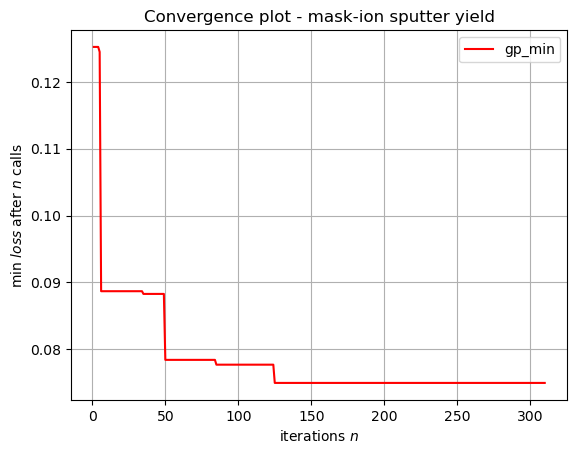

In [ ]:
losses = []
iterations = list(range(1, 300))  # 1到100的迭代次数

# 遍历1到100，加载每个文件，并提取loss
for n in iterations:
    filename = f'./{path}/hyperopt/iteration_{n}.npy'
    data = np.load(filename, allow_pickle=True).item()
    losses.append(data['loss'])

    # print(n, data['params'])
    if data['loss'] >= np.array(losses).max():
        print(f"n: {n}, loss: {data['loss']}")
        overlap_show(n, "./sf_250410_1_1.jpg", "./sf_250410_1_2.jpg", path, np.array([[60, 105], [0, 80]]))

# np.array([[60, 105], [0, 80]])
react_prob_chemical_0 = []

fig, axs = plt.subplots(figsize=(10, 6))
axs.plot(iterations, losses, marker='*', linestyle='--')
axs.set_xlabel("Iteration (n)")
axs.set_ylabel("Loss")
axs.set_title("Loss over Iterations")
axs.grid(True)

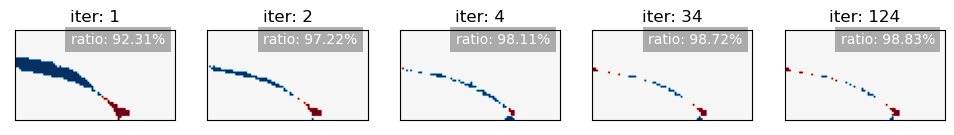

go to calibration_simplefilm_GP_1003_fitting_o2.py

```bash
vim calibration_simplefilm_GP_1003_fitting_o2.py

```
change the parameters in line 413


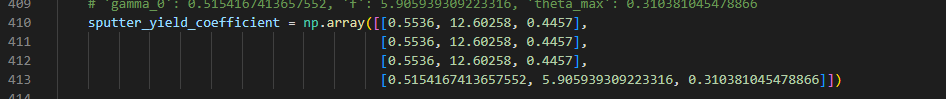




第2段階では、マスク側sputter yieldパラメータを固定したうえで、Si および SiOF に関連する反応パラメータを最適化する。


```bash
python3 Skopt_paper_1003.py
```

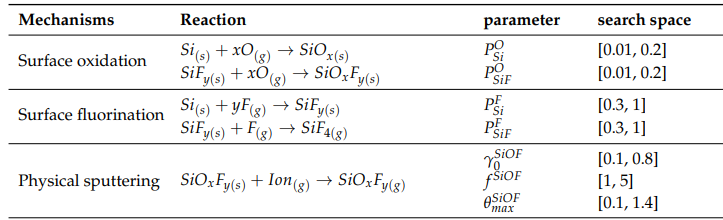

In [ ]:
path = "calibration_1014_paper_gpmin"

res = load(f"./{path}/checkpoint.pkl")
x0 = res.x_iters
y0 = res.func_vals

# print(x0)

from functools import partial
example = "hart6"


# yscale="log"
title = "Convergence plot"

plot = plot_convergence("gp_min", res,
                        yscale=None,
                        title=title)

plt.show()

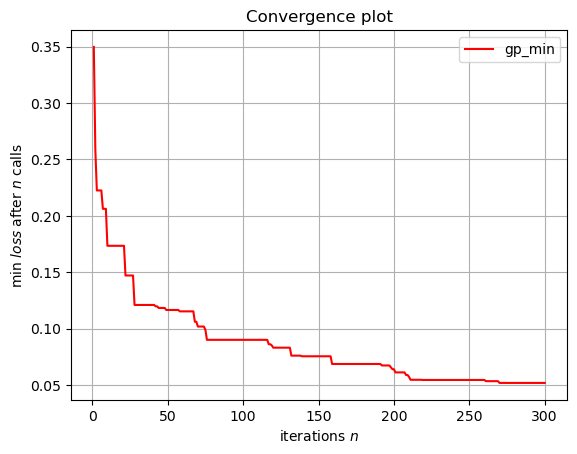

In [ ]:
losses = []
iterations = list(range(1, 300))  # 1到100的迭代次数


# path = "calibration_1014_paper_gpmin"
# 遍历1到100，加载每个文件，并提取loss
for n in iterations:
    filename = f'./{path}/hyperopt/iteration_{n}.npy'
    data = np.load(filename, allow_pickle=True).item()
    losses.append(data['loss'])

    # print(n, data['params'])
    if data['loss'] >= np.array(losses).max():
        print(f"n: {n}, loss: {data['loss']}")

react_prob_chemical_0 = []

fig, axs = plt.subplots(figsize=(10, 6))
axs.plot(iterations, losses, marker='*', linestyle='--')
axs.set_xlabel("Iteration (n)")
axs.set_ylabel("Loss")
axs.set_title("Loss over Iterations")
axs.grid(True)

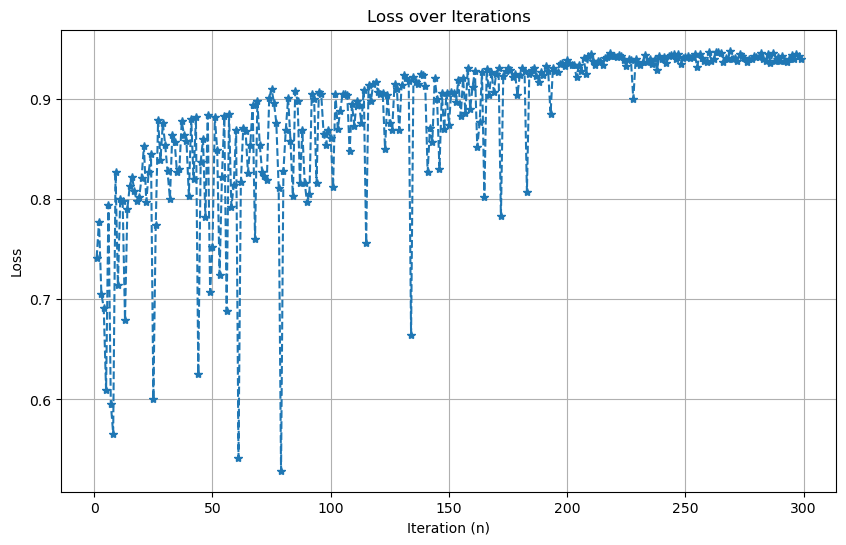

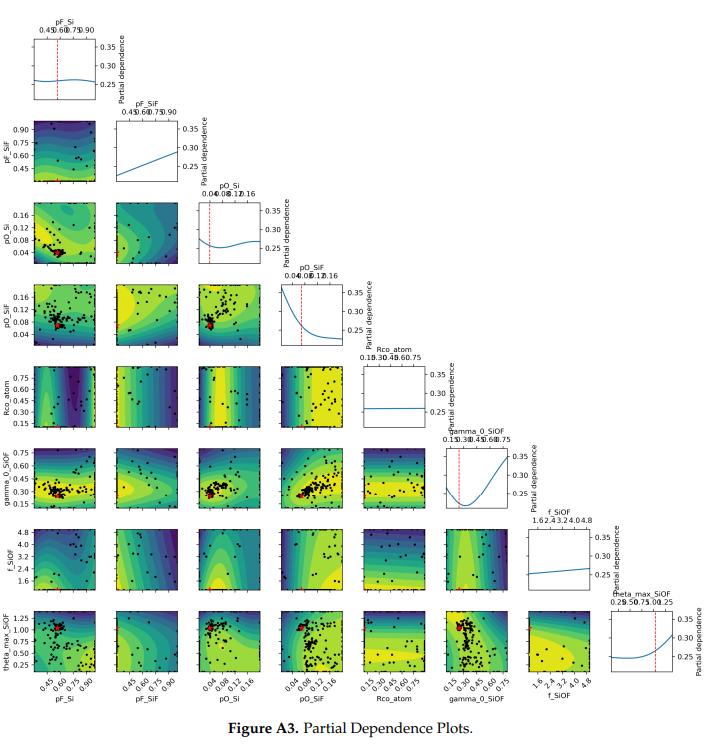